## Wavelet data generation..

In [1]:
def func(cls):
  img_names = os.listdir('genres_original/'+cls)
  os.makedirs('wavelets/train/'+cls)
  os.makedirs('wavelets/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x)
    plt.savefig('wavelets/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
  
  cnt = 0
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    #plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x)
    plt.savefig('wavelets/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()

In [2]:
import os
classes = [a for a in os.listdir('genres_original') if '.' not in a]
print(classes)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Spectrogram generation..

In [3]:
import librosa
import matplotlib.pyplot as plt
import librosa.display


def func1(cls):
  img_names = os.listdir('genres_original/'+cls)
  os.makedirs('spectrogram/train/'+cls)
  os.makedirs('spectrogram/test/'+cls)
  print(cls)
  train_names = img_names[:60]
  test_names = img_names[60:]
  cnt = 0
  for nm in train_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/train/'+cls+'/'+str(cnt)+'.png')
    plt.close()
  
  cnt = 0
  for nm in test_names:
    cnt+=1
    x , sr = librosa.load('genres_original/'+cls+'/'+nm)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb)
    plt.savefig('spectrogram/test/'+cls+'/'+str(cnt)+'.png')
    plt.close()

In [4]:
import os
classes = [a for a in os.listdir('genres_original') if '.' not in a]
print(classes)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Model training..

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf


import cv2
import os

import numpy as np

In [6]:
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
img_size = 256
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
train = get_data('spectrogram/train')
val = get_data('spectrogram/test')

C:\Users\CHENYU\AppData\Local\Temp\ipykernel_34572\802610576.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [8]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [10]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

In [11]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
history = model.fit(x_train,y_train,epochs = 500, validation_data = (x_val, y_val))

Epoch 1/500


c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 2/19 [==>...........................] - ETA: 12s - loss: 2.3632 - accuracy: 0.1719

KeyboardInterrupt: 

In [13]:
import pickle
model.save_weights('500_epoch_simple_lr.cpkt')

pickle.dump(history.history, open('history_500_epoch_simple.pkl','wb'))

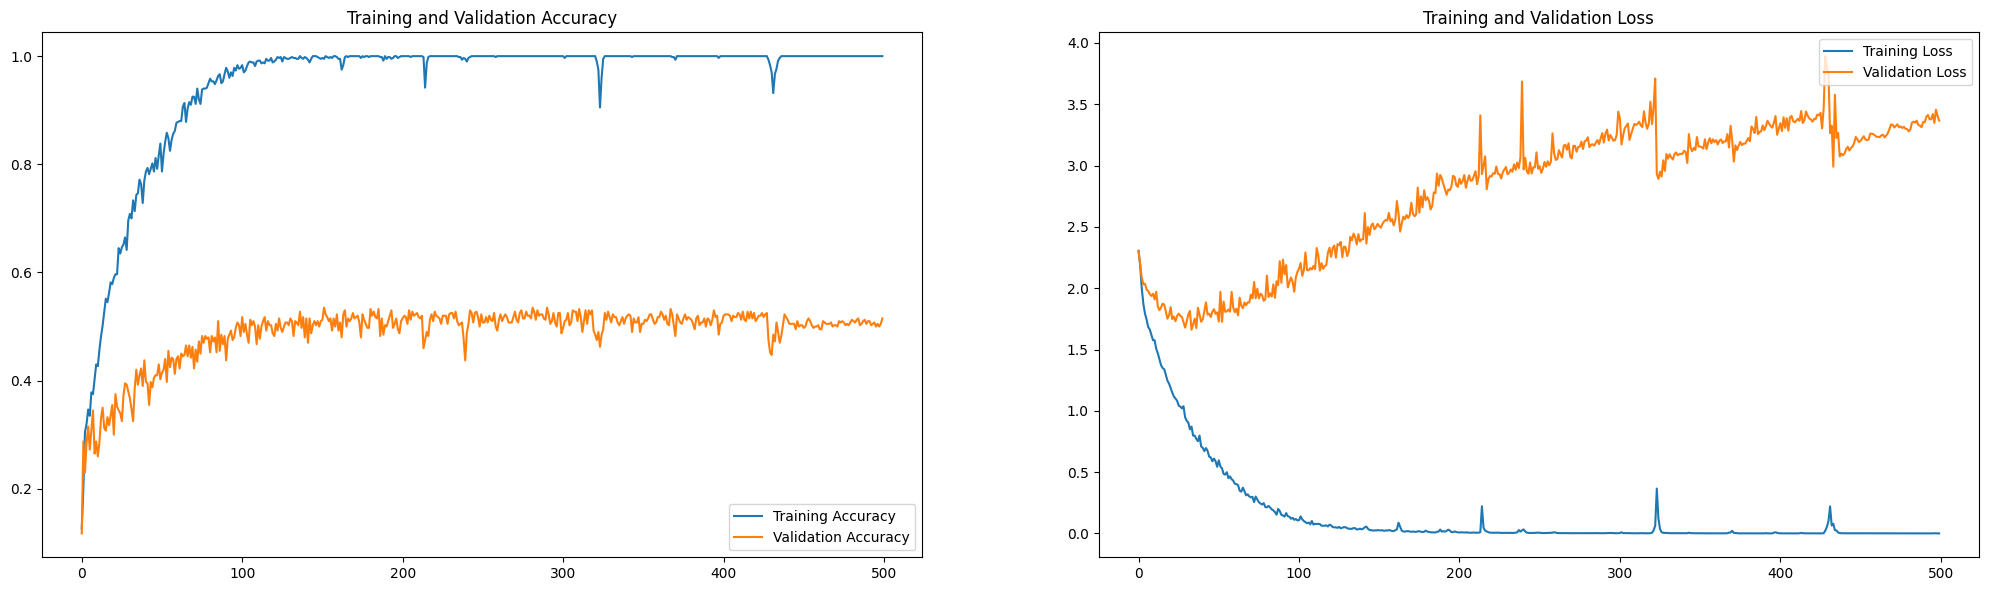

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
import pickle
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('sim_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [16]:
predictions = model.predict(x_val)
predictions=np.argmax(predictions,axis=1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = labels))

13/13 [==============================] - 3s 181ms/step
              precision    recall  f1-score   support

       blues       0.48      0.50      0.49        40
   classical       0.91      0.80      0.85        40
     country       0.43      0.45      0.44        40
       disco       0.43      0.47      0.45        40
      hiphop       0.37      0.62      0.47        40
        jazz       0.56      0.45      0.50        40
       metal       0.72      0.72      0.73        40
         pop       0.79      0.57      0.67        40
      reggae       0.30      0.28      0.29        40
        rock       0.34      0.28      0.31        40

    accuracy                           0.52       400
   macro avg       0.53      0.52      0.52       400
weighted avg       0.53      0.52      0.52       400



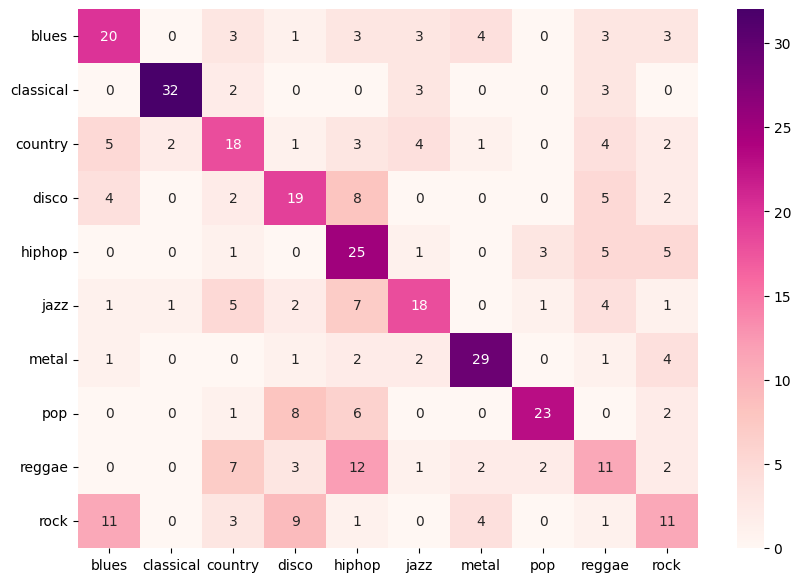

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx1.png',bbox_inches = 'tight')

# Transfer Learning based modeling

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")

In [19]:
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(10, activation="softmax")                                     
                                ])

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500


c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 22s 1s/step - loss: 2.1583 - accuracy: 0.2217 - val_loss: 1.9633 - val_accuracy: 0.2975
Epoch 2/500
19/19 [==============================] - 18s 956ms/step - loss: 1.6818 - accuracy: 0.4083 - val_loss: 1.8221 - val_accuracy: 0.2950
Epoch 3/500
19/19 [==============================] - 18s 992ms/step - loss: 1.4998 - accuracy: 0.4767 - val_loss: 1.7396 - val_accuracy: 0.3300
Epoch 4/500
19/19 [==============================] - 19s 1s/step - loss: 1.3938 - accuracy: 0.5150 - val_loss: 1.7002 - val_accuracy: 0.3350
Epoch 5/500
19/19 [==============================] - 16s 825ms/step - loss: 1.3303 - accuracy: 0.5183 - val_loss: 1.6659 - val_accuracy: 0.3725
Epoch 6/500
19/19 [==============================] - 14s 736ms/step - loss: 1.2559 - accuracy: 0.5333 - val_loss: 1.6316 - val_accuracy: 0.3900
Epoch 7/500
19/19 [==============================] - 15s 822ms/step - loss: 1.2064 - accuracy: 0.5717 - val_loss: 1.6011 - val_accuracy: 0.3775
Epoch 8/50

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
import pickle
model.save_weights('500_epoch_tr_lr.cpkt')

pickle.dump(history1.history, open('history_500_epoch_tr.pkl','wb'))

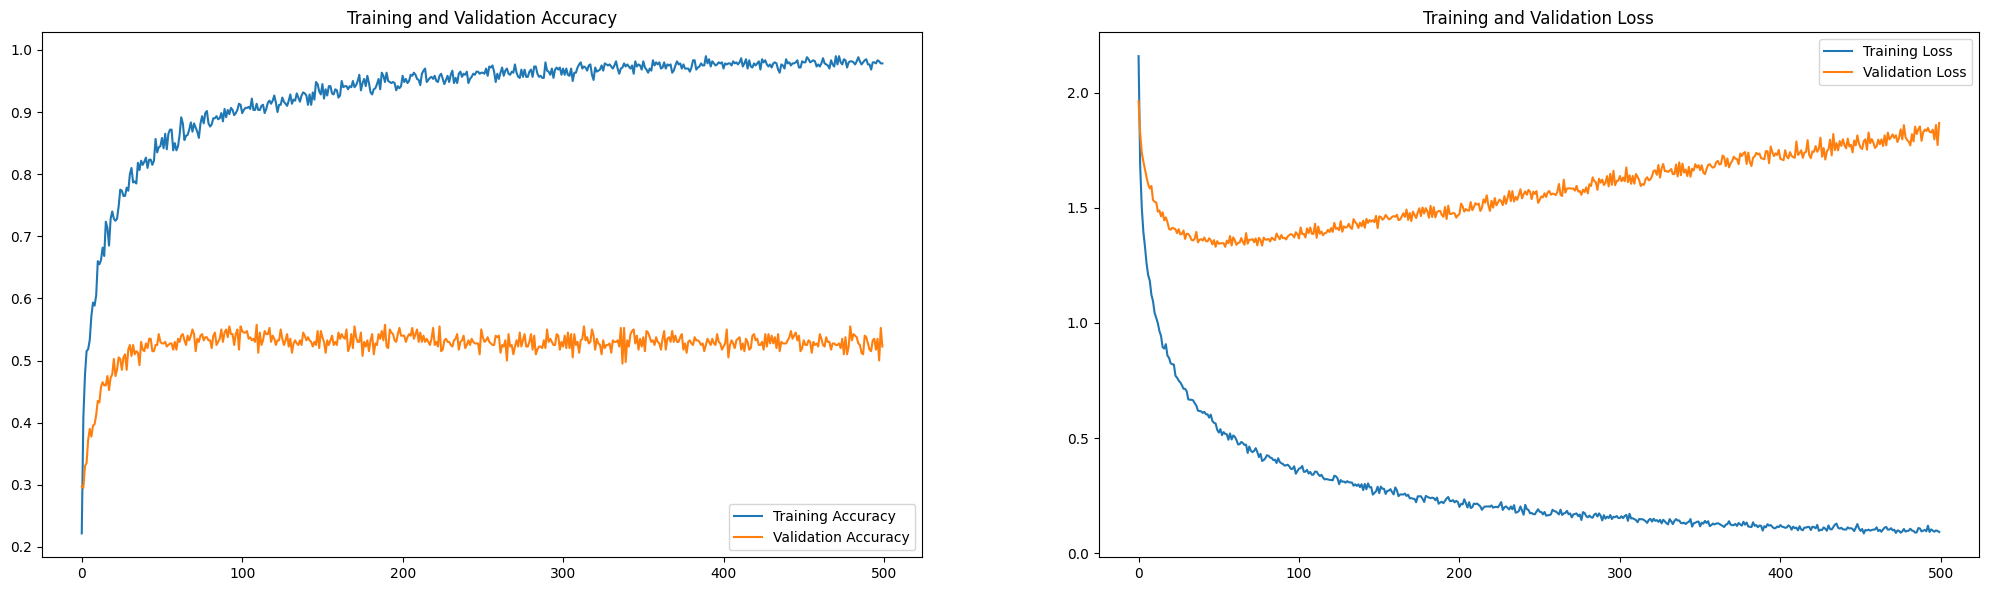

In [23]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
import pickle
history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [25]:
predictions = model.predict(x_val)
predictions=np.argmax(predictions,axis=1)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = labels))

13/13 [==============================] - 9s 560ms/step
              precision    recall  f1-score   support

       blues       0.42      0.62      0.50        40
   classical       0.91      0.75      0.82        40
     country       0.38      0.38      0.38        40
       disco       0.47      0.45      0.46        40
      hiphop       0.43      0.72      0.54        40
        jazz       0.69      0.55      0.61        40
       metal       0.69      0.55      0.61        40
         pop       0.84      0.65      0.73        40
      reggae       0.41      0.28      0.33        40
        rock       0.28      0.28      0.28        40

    accuracy                           0.52       400
   macro avg       0.55      0.52      0.53       400
weighted avg       0.55      0.52      0.53       400



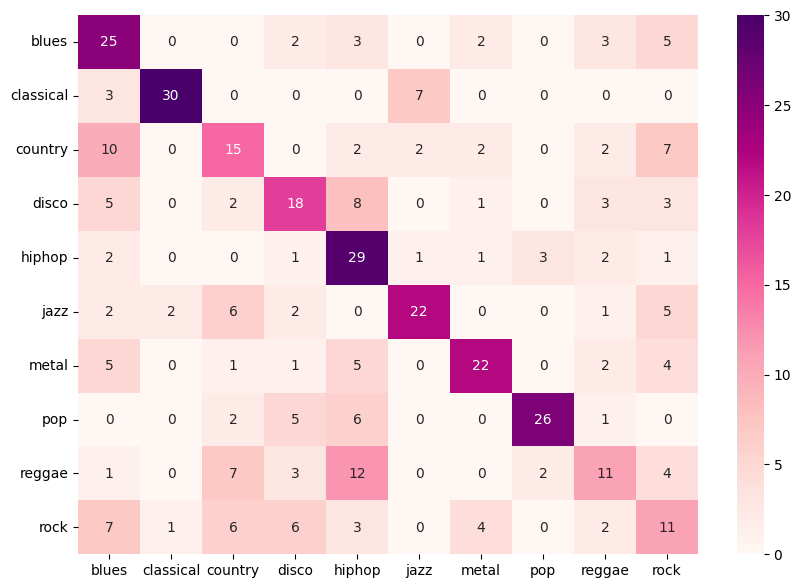

In [26]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx2.png',bbox_inches = 'tight')

In [27]:
model.save_weights('500_epoch_transfer_lr.cpkt')
pickle.dump(history1.history, open('history_500_epoch_tr.pkl','wb'))


## Multi-Model Training

In [28]:
sp_train = get_data('spectrogram/train')
sp_val = get_data('spectrogram/test')

wv_train = get_data('wavelets/train')
wv_val = get_data('wavelets/test')

C:\Users\CHENYU\AppData\Local\Temp\ipykernel_65512\802610576.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [29]:
x_sp_train = []
y_sp_train = []
x_sp_val = []
y_sp_val = []

for feature, label in sp_train:
  x_sp_train.append(feature)
  y_sp_train.append(label)

for feature, label in sp_val:
  x_sp_val.append(feature)
  y_sp_val.append(label)

# Normalize the data
x_sp_train = np.array(x_sp_train) / 255
x_sp_val = np.array(x_sp_val) / 255

x_sp_train.reshape(-1, img_size, img_size, 1)
y_sp_train = np.array(y_sp_train)

x_sp_val.reshape(-1, img_size, img_size, 1)
y_sp_val = np.array(y_sp_val)

In [30]:
x_wv_train = []
y_wv_train = []
x_wv_val = []
y_wv_val = []

for feature, label in wv_train:
  x_wv_train.append(feature)
  y_wv_train.append(label)

for feature, label in wv_val:
  x_wv_val.append(feature)
  y_wv_val.append(label)

# Normalize the data
x_wv_train = np.array(x_wv_train) / 255
x_wv_val = np.array(x_wv_val) / 255

x_wv_train.reshape(-1, img_size, img_size, 1)
y_wv_train = np.array(y_wv_train)

x_wv_val.reshape(-1, img_size, img_size, 1)
y_wv_val = np.array(y_wv_val)

In [31]:
datagen_sp = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_sp.fit(x_sp_train)

datagen_wv = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_wv.fit(x_wv_train)

In [32]:
input_sp = keras.Input(shape=(256,256,3))
input_wv = keras.Input(shape=(256,256,3))

x = Conv2D(32,3,padding="same", activation="relu")(input_sp)
x = MaxPool2D()(x)
x = Conv2D(64, 3, padding="same", activation="relu")(x)
x = MaxPool2D()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(128,activation="relu")(x)
x = keras.Model(inputs=input_sp, outputs=x)

y = Conv2D(32,3,padding="same", activation="relu")(input_wv)
y = MaxPool2D()(y)
y = Conv2D(64, 3, padding="same", activation="relu")(y)
y = MaxPool2D()(y)
y = Dropout(0.4)(y)
y = Flatten()(y)
y = Dense(128,activation="relu")(y)
y = keras.Model(inputs=input_wv, outputs=y)

from tensorflow.keras.layers import concatenate
combined = concatenate([x.output, y.output])

z = Dense(32, activation="relu")(combined)
z = Dense(10, activation="softmax")(z)

model = keras.Model(inputs=[x.input, y.input], outputs=z)

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                           

In [34]:
opt = Adam(lr=0.0001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [35]:
history2 = model.fit([x_sp_train,x_wv_train],y_sp_train,epochs = 500, validation_data = ([x_sp_val,x_wv_val], y_sp_val))
import pickle
model.save_weights('500_epoch_multi_lr.cpkt')
pickle.dump(history2.history, open('history_500_epoch_multi.pkl','wb'))

Epoch 1/500


c:\Users\CHENYU\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 38s 2s/step - loss: 2.4228 - accuracy: 0.1117 - val_loss: 2.3050 - val_accuracy: 0.1250
Epoch 2/500
19/19 [==============================] - 34s 2s/step - loss: 2.2980 - accuracy: 0.1067 - val_loss: 2.3036 - val_accuracy: 0.0400
Epoch 3/500
19/19 [==============================] - 35s 2s/step - loss: 2.2773 - accuracy: 0.1400 - val_loss: 2.2484 - val_accuracy: 0.1050
Epoch 4/500
19/19 [==============================] - 29s 2s/step - loss: 2.2240 - accuracy: 0.1533 - val_loss: 2.2065 - val_accuracy: 0.1875
Epoch 5/500
19/19 [==============================] - 29s 2s/step - loss: 2.1963 - accuracy: 0.1733 - val_loss: 2.2460 - val_accuracy: 0.1325
Epoch 6/500
19/19 [==============================] - 29s 2s/step - loss: 2.1557 - accuracy: 0.1817 - val_loss: 2.1815 - val_accuracy: 0.1500
Epoch 7/500
19/19 [==============================] - 28s 1s/step - loss: 2.1327 - accuracy: 0.2083 - val_loss: 2.2178 - val_accuracy: 0.1675
Epoch 8/500
19/19 [======

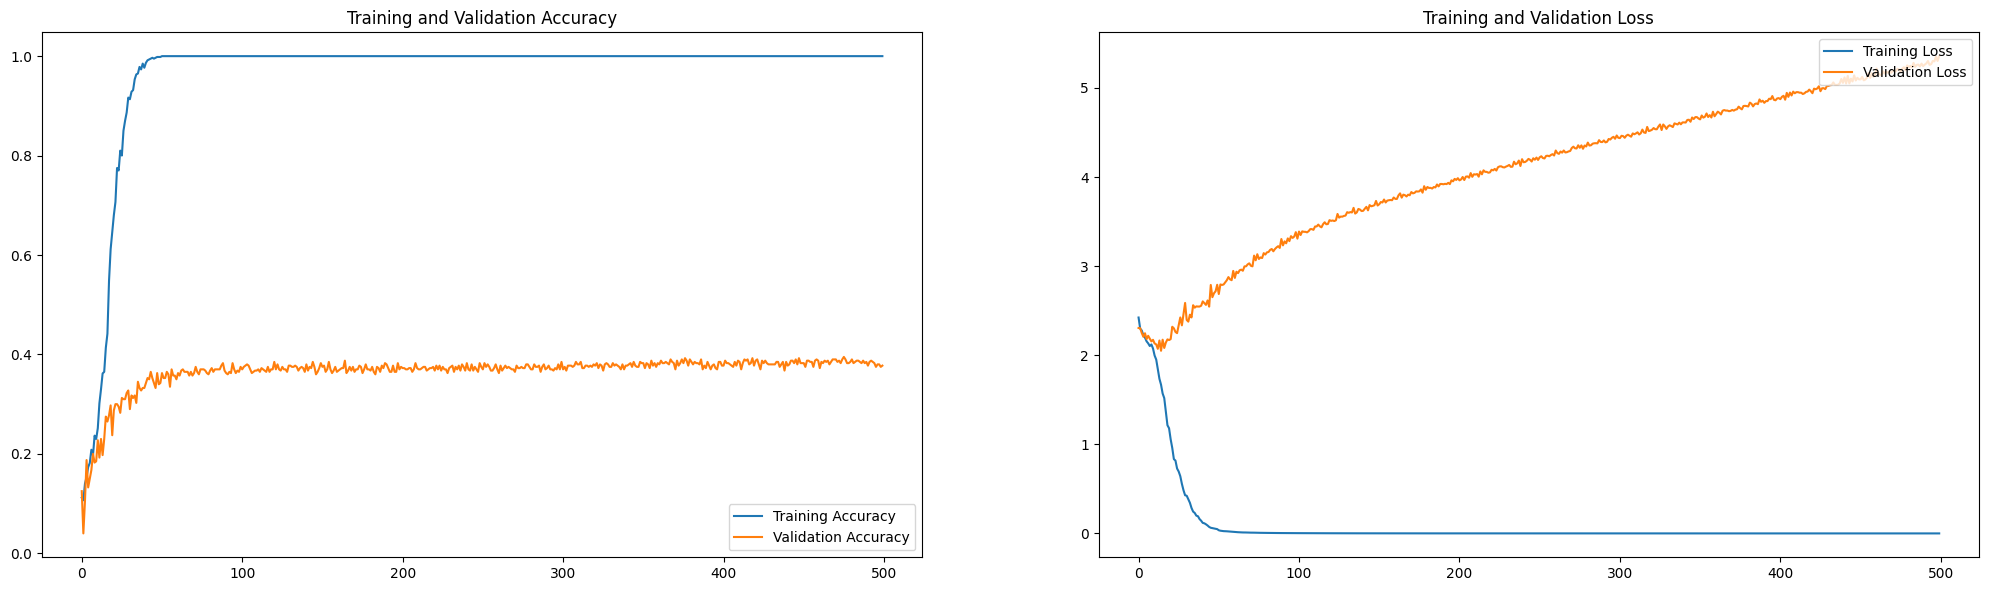

In [36]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
import pickle
history = pickle.load(open('history_500_epoch_multi.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('multi_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [38]:
predictions = model.predict([x_sp_val,x_wv_val])
print(classification_report(y_wv_val, np.argmax(predictions, axis=1), target_names = labels))

13/13 [==============================] - 6s 448ms/step
              precision    recall  f1-score   support

       blues       0.19      0.23      0.21        40
   classical       0.80      0.60      0.69        40
     country       0.16      0.12      0.14        40
       disco       0.43      0.33      0.37        40
      hiphop       0.29      0.45      0.35        40
        jazz       0.31      0.33      0.32        40
       metal       0.48      0.57      0.52        40
         pop       0.71      0.72      0.72        40
      reggae       0.33      0.33      0.33        40
        rock       0.14      0.10      0.12        40

    accuracy                           0.38       400
   macro avg       0.38      0.38      0.38       400
weighted avg       0.38      0.38      0.38       400



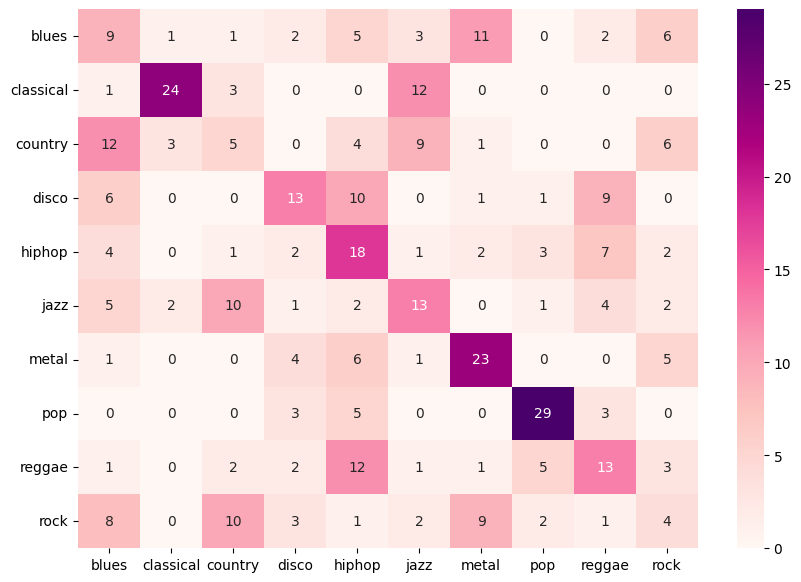

In [39]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
predictions = np.argmax(predictions, axis=1)
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in labels],
              columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx3.png',bbox_inches = 'tight')

In [43]:
epochs_range = range(500)
import matplotlib.pyplot as plt
import pickle 
history = pickle.load(open('history_500_epoch_simple.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

history = pickle.load(open('history_500_epoch_tr.pkl','rb'))
acc1 = history['accuracy']
val_acc1 = history['val_accuracy']
loss1 = history['loss']
val_loss1 = history['val_loss']

history = pickle.load(open('history_500_epoch_multi.pkl','rb'))
acc2 = history['accuracy']
val_acc2 = history['val_accuracy']
loss2 = history['loss']
val_loss2 = history['val_loss']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='CNN Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='CNN Validation Accuracy', c='red', linewidth=4)
ax1.plot(epochs_range, acc1, label='Transfer learning Training Accuracy', c = '#e72866', linewidth=4)
ax1.plot(epochs_range, val_acc1, label='Transfer learning Validation Accuracy', c='#282ec7', linewidth=4)
ax1.plot(epochs_range, acc2, label='Multi modal Training Accuracy', c = '#171c1c', linewidth=4)
ax1.plot(epochs_range, val_acc2, label='Multi modal Validation Accuracy', c='#62176e', linewidth=4)

ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='CNN Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='CNN Validation Loss', c='red', linewidth=4)
ax2.plot(epochs_range, loss1, label='Transfer learning Training Loss',c = '#c72866', linewidth=4)
ax2.plot(epochs_range, val_loss1, label='Transfer learning Validation Loss', c='#282ec7', linewidth=4)
ax2.plot(epochs_range, loss2, label='Multi modal Training Loss',c = '#171c1c', linewidth=4)
ax2.plot(epochs_range, val_loss2, label='Multi modal learning Validation Loss', c='#62176e', linewidth=4)

ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('all_1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

## Transfer learning+BILSTM

In [9]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model

In [10]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")


In [11]:
mobilenetv2.trainable = False

In [12]:
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(lstm_input)  # 使用Bidirectional LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別

In [13]:
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [14]:
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          7344128   
 l)                                                              
                                                             

In [16]:
history3 = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500
19/19 [==============================] - 22s 894ms/step - loss: 1.7368 - accuracy: 0.3450 - val_loss: 1.8720 - val_accuracy: 0.2850
Epoch 2/500
19/19 [==============================] - 17s 908ms/step - loss: 1.2604 - accuracy: 0.5150 - val_loss: 1.6656 - val_accuracy: 0.3975
Epoch 3/500
19/19 [==============================] - 17s 901ms/step - loss: 1.0309 - accuracy: 0.6150 - val_loss: 1.5982 - val_accuracy: 0.4425
Epoch 4/500
19/19 [==============================] - 16s 862ms/step - loss: 0.9141 - accuracy: 0.6767 - val_loss: 1.4922 - val_accuracy: 0.4700
Epoch 5/500
19/19 [==============================] - 16s 871ms/step - loss: 0.8055 - accuracy: 0.7150 - val_loss: 1.4257 - val_accuracy: 0.4800
Epoch 6/500
19/19 [==============================] - 15s 811ms/step - loss: 0.6805 - accuracy: 0.7700 - val_loss: 1.4924 - val_accuracy: 0.5075
Epoch 7/500
19/19 [==============================] - 15s 818ms/step - loss: 0.6107 - accuracy: 0.7867 - val_loss: 1.5217 - val_accuracy:

In [25]:
import pickle
model.save_weights('500_epoch_tr_BILSTM.cpkt')

pickle.dump(history3.history, open('history_500_epoch_tr_BILSTM.pkl','wb'))

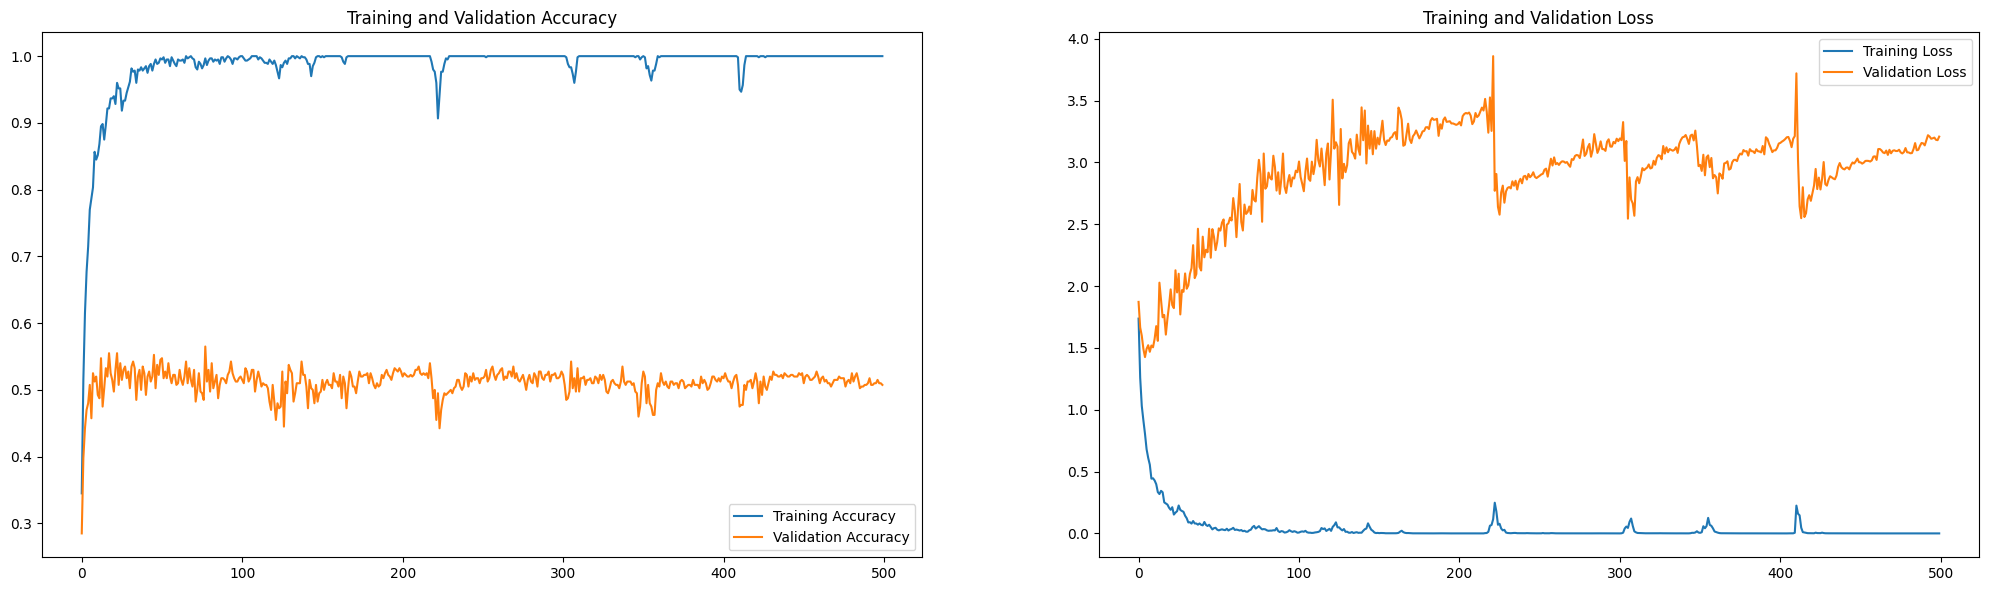

In [26]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
import pickle
history = pickle.load(open('history_500_epoch_tr_BILSTM.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_BILSTM_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [28]:
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數


13/13 [==============================] - 6s 435ms/step


In [29]:
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]

In [30]:
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))

              precision    recall  f1-score   support

       blues       0.46      0.55      0.50        40
   classical       0.83      0.85      0.84        40
     country       0.40      0.42      0.41        40
       disco       0.40      0.47      0.44        40
      hiphop       0.40      0.65      0.50        40
        jazz       0.76      0.55      0.64        40
       metal       0.72      0.57      0.64        40
         pop       0.76      0.65      0.70        40
      reggae       0.26      0.23      0.24        40
        rock       0.18      0.12      0.15        40

    accuracy                           0.51       400
   macro avg       0.52      0.51      0.51       400
weighted avg       0.52      0.51      0.51       400



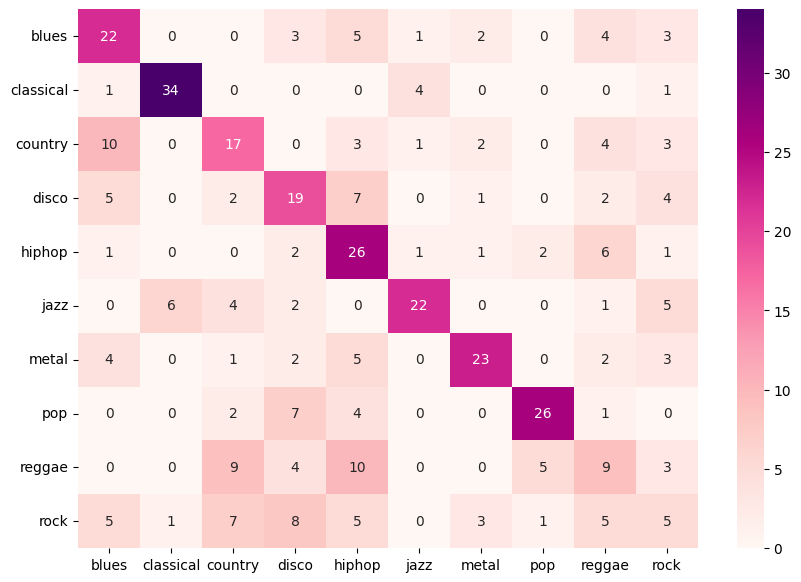

In [32]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx4.png',bbox_inches = 'tight')

## Transfer learning+LSTM

In [9]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model

In [10]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")


In [11]:
mobilenetv2.trainable = False

In [12]:
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
lstm_layer = LSTM(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2)(lstm_input) # 使用LSTM處理特徵序列
lstm_output = Flatten()(lstm_layer)  # 將LSTM輸出扁平化
output = Dense(10, activation='softmax')(lstm_output)  # 假設有10個類別

In [13]:
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [14]:
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            3672064   
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [16]:
history4 = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500
19/19 [==============================] - 21s 929ms/step - loss: 1.8044 - accuracy: 0.3617 - val_loss: 1.7532 - val_accuracy: 0.3375
Epoch 2/500
19/19 [==============================] - 14s 769ms/step - loss: 1.3266 - accuracy: 0.5167 - val_loss: 1.7916 - val_accuracy: 0.3575
Epoch 3/500
19/19 [==============================] - 13s 706ms/step - loss: 1.1801 - accuracy: 0.5500 - val_loss: 1.5943 - val_accuracy: 0.4275
Epoch 4/500
19/19 [==============================] - 13s 715ms/step - loss: 1.0027 - accuracy: 0.6450 - val_loss: 1.5112 - val_accuracy: 0.4750
Epoch 5/500
19/19 [==============================] - 13s 699ms/step - loss: 0.8514 - accuracy: 0.6883 - val_loss: 1.4471 - val_accuracy: 0.4675
Epoch 6/500
19/19 [==============================] - 13s 701ms/step - loss: 0.8305 - accuracy: 0.7050 - val_loss: 1.5454 - val_accuracy: 0.4350
Epoch 7/500
19/19 [==============================] - 17s 919ms/step - loss: 0.7630 - accuracy: 0.7383 - val_loss: 1.4237 - val_accuracy:

In [17]:
import pickle
model.save_weights('500_epoch_tr_LSTM.cpkt')

pickle.dump(history4.history, open('history_500_epoch_tr_LSTM.pkl','wb'))

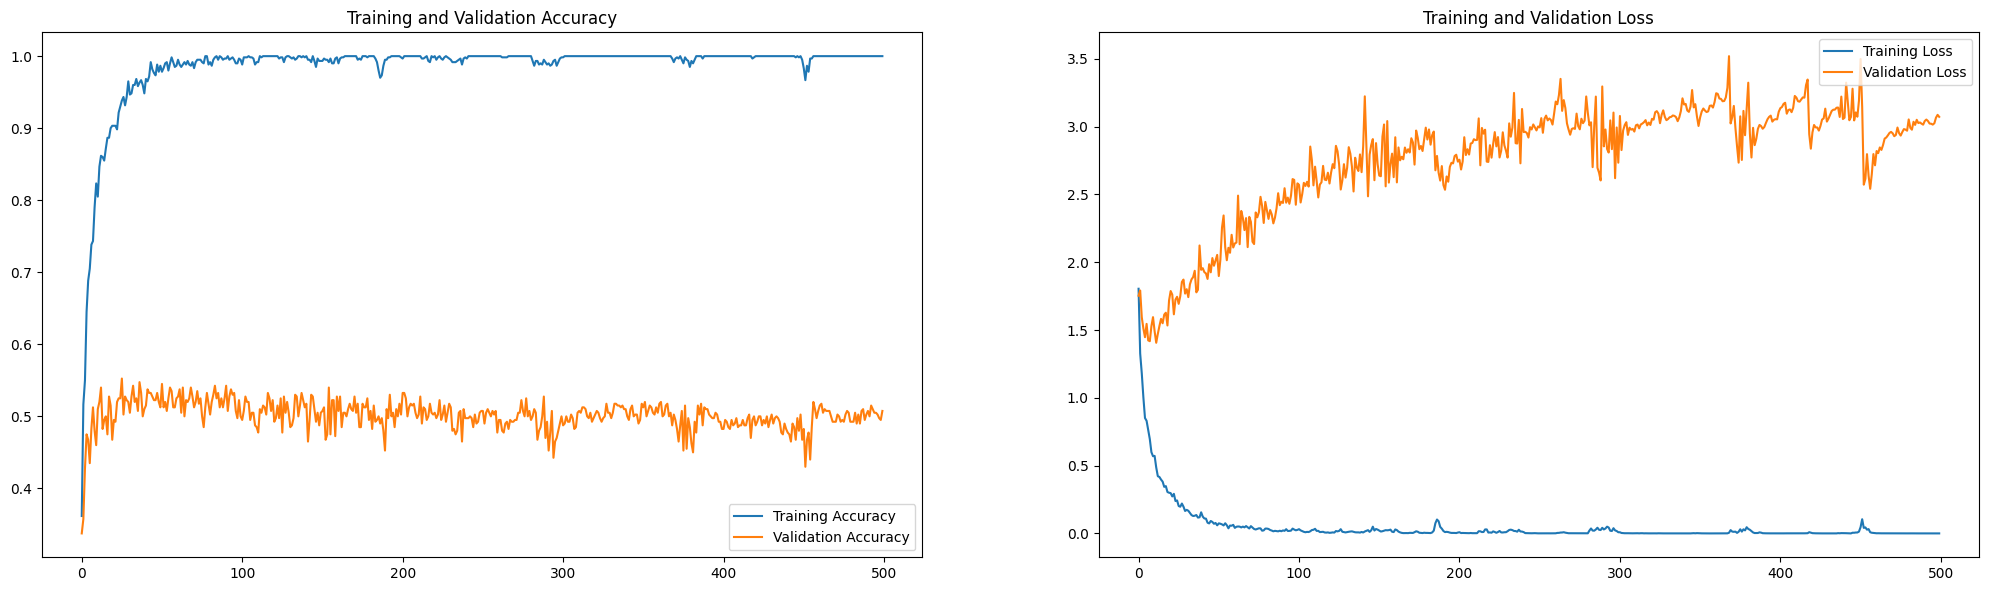

In [18]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import pickle
history = pickle.load(open('history_500_epoch_tr_LSTM.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_LSTM_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [20]:
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數


13/13 [==============================] - 7s 446ms/step


In [21]:
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]

In [22]:
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))

              precision    recall  f1-score   support

       blues       0.47      0.55      0.51        40
   classical       0.83      0.88      0.85        40
     country       0.39      0.35      0.37        40
       disco       0.45      0.50      0.48        40
      hiphop       0.39      0.68      0.49        40
        jazz       0.70      0.47      0.57        40
       metal       0.69      0.68      0.68        40
         pop       0.78      0.62      0.69        40
      reggae       0.26      0.25      0.26        40
        rock       0.16      0.10      0.12        40

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.50       400
weighted avg       0.51      0.51      0.50       400



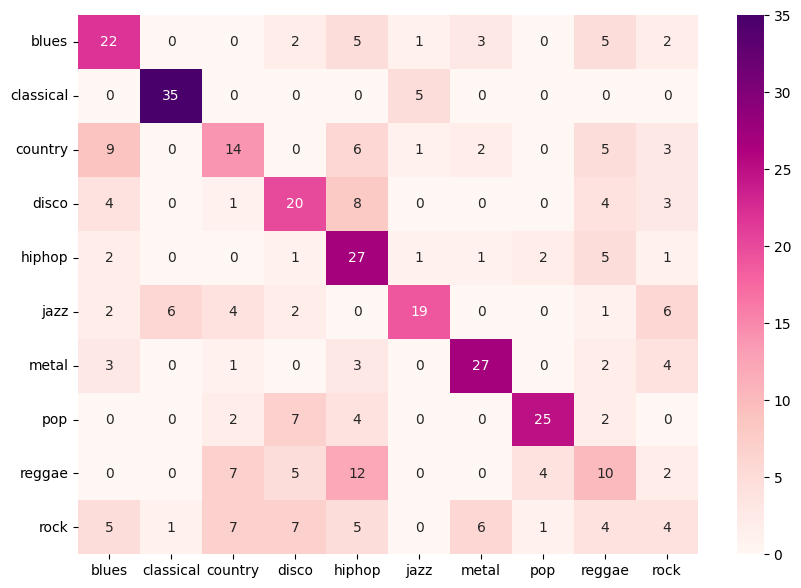

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx5.png',bbox_inches = 'tight')

## Transfer learning+RNN

In [9]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, LSTM, TimeDistributed, Bidirectional
from keras.models import Model

In [10]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")


In [11]:
mobilenetv2.trainable = False

In [12]:
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
lstm_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
rnn_layer = keras.layers.SimpleRNN(512, return_sequences=True, dropout=0.2)(lstm_input) # 使用RNN處理特徵序列
rnn_output = Flatten()(rnn_layer)  # 將RNN輸出扁平化
output = Dense(10, activation='softmax')(rnn_output) # 假設有10個類別

In [13]:
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [14]:
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1, 512)            918016    
                                                                 
 flatten (Flatten)           (None, 512)               0     

In [16]:
history5 = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500
19/19 [==============================] - 20s 914ms/step - loss: 1.9860 - accuracy: 0.3417 - val_loss: 1.9849 - val_accuracy: 0.3300
Epoch 2/500
19/19 [==============================] - 14s 777ms/step - loss: 1.3688 - accuracy: 0.5050 - val_loss: 1.7107 - val_accuracy: 0.3875
Epoch 3/500
19/19 [==============================] - 14s 740ms/step - loss: 1.1389 - accuracy: 0.5817 - val_loss: 1.6460 - val_accuracy: 0.4200
Epoch 4/500
19/19 [==============================] - 14s 748ms/step - loss: 0.9950 - accuracy: 0.6400 - val_loss: 1.4558 - val_accuracy: 0.4700
Epoch 5/500
19/19 [==============================] - 14s 737ms/step - loss: 0.9609 - accuracy: 0.6483 - val_loss: 1.7588 - val_accuracy: 0.4300
Epoch 6/500
19/19 [==============================] - 14s 745ms/step - loss: 0.8822 - accuracy: 0.6917 - val_loss: 1.5641 - val_accuracy: 0.4575
Epoch 7/500
19/19 [==============================] - 14s 776ms/step - loss: 0.7674 - accuracy: 0.7200 - val_loss: 1.4306 - val_accuracy:

In [17]:
import pickle
model.save_weights('500_epoch_tr_RNN.cpkt')

pickle.dump(history5.history, open('history_500_epoch_tr_RNN.pkl','wb'))

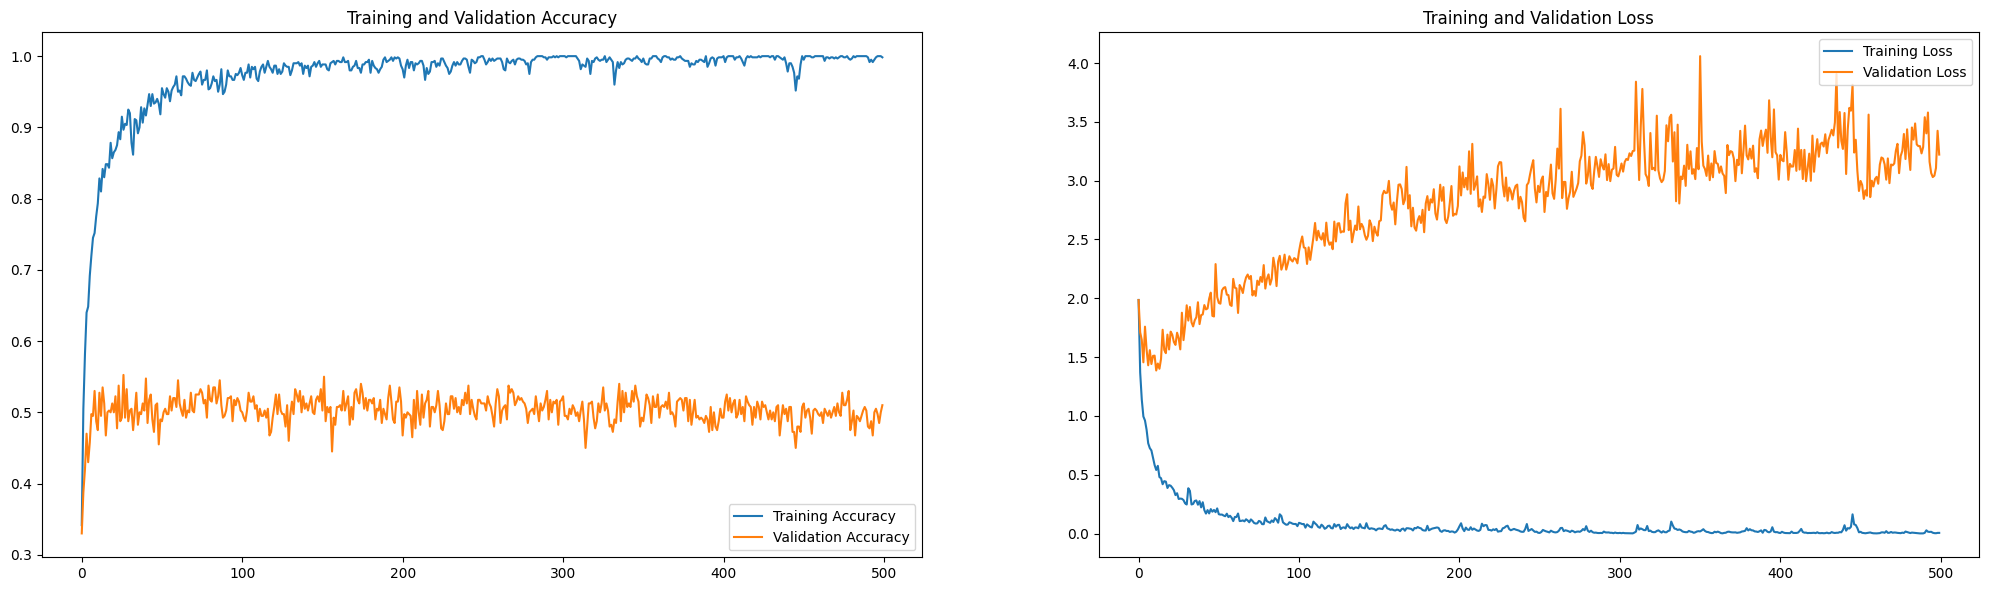

In [18]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import pickle
history = pickle.load(open('history_500_epoch_tr_RNN.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_RNN_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [20]:
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數


13/13 [==============================] - 7s 440ms/step


In [21]:
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]

In [22]:
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))

              precision    recall  f1-score   support

       blues       0.39      0.53      0.45        40
   classical       0.89      0.78      0.83        40
     country       0.47      0.40      0.43        40
       disco       0.51      0.45      0.48        40
      hiphop       0.41      0.70      0.52        40
        jazz       0.66      0.57      0.61        40
       metal       0.79      0.47      0.59        40
         pop       0.74      0.65      0.69        40
      reggae       0.30      0.25      0.27        40
        rock       0.26      0.30      0.28        40

    accuracy                           0.51       400
   macro avg       0.54      0.51      0.52       400
weighted avg       0.54      0.51      0.52       400



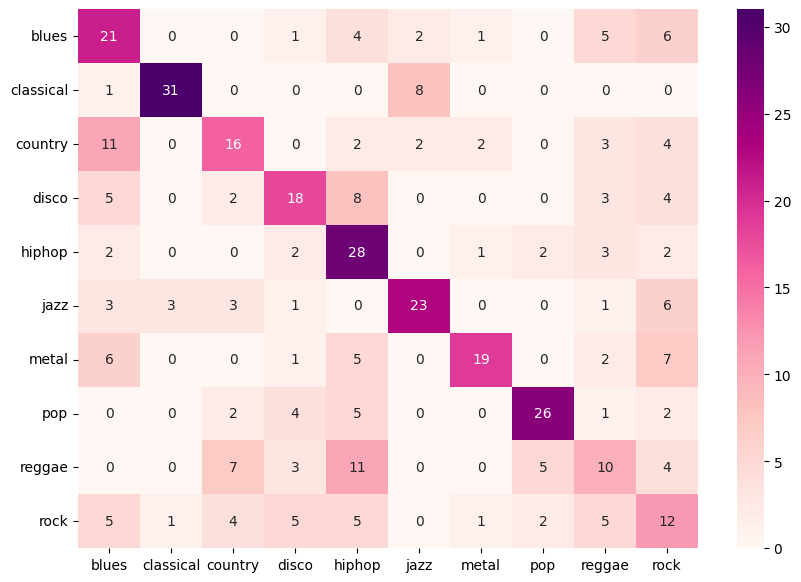

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx6.png',bbox_inches = 'tight')

## Transfer learning+GRU

In [9]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, GRU, TimeDistributed, Bidirectional
from keras.models import Model

In [10]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights = "imagenet")


In [11]:
mobilenetv2.trainable = False

In [12]:
input_image = Input(shape=(img_size, img_size, 3))  # 單一靜態圖像
encoded_image = mobilenetv2(input_image)  # 使用MobileNetV2進行特徵提取
global_avg_pooling = GlobalAveragePooling2D()(encoded_image)  # 對特徵圖進行全局平均池化
gru_input = tf.keras.layers.Reshape((1, -1))(global_avg_pooling)  # 將特徵扁平化成(1, 特徵數)形狀
gru_layer = Bidirectional(GRU(512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(gru_input)  # 使用Bidirectional GRU處理特徵序列
gru_output = Flatten()(gru_layer)  # 將GRU輸出扁平化
output = Dense(10, activation='softmax')(gru_output)  # 假設有10個類別

In [13]:
# 創建模型
model = Model(inputs=input_image, outputs=output)
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

In [14]:
# 編譯模型
model.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
# 打印模型摘要
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 reshape (Reshape)           (None, 1, 1280)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 1024)          5511168   
 l)                                                              
                                                             

In [16]:
history6 = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500
19/19 [==============================] - 22s 904ms/step - loss: 1.8814 - accuracy: 0.3500 - val_loss: 1.8030 - val_accuracy: 0.2900
Epoch 2/500
19/19 [==============================] - 15s 823ms/step - loss: 1.2396 - accuracy: 0.5400 - val_loss: 1.6514 - val_accuracy: 0.3925
Epoch 3/500
19/19 [==============================] - 15s 790ms/step - loss: 1.0504 - accuracy: 0.6067 - val_loss: 1.5188 - val_accuracy: 0.4150
Epoch 4/500
19/19 [==============================] - 15s 809ms/step - loss: 0.9161 - accuracy: 0.6667 - val_loss: 1.3986 - val_accuracy: 0.4900
Epoch 5/500
19/19 [==============================] - 15s 794ms/step - loss: 0.7776 - accuracy: 0.7250 - val_loss: 1.5104 - val_accuracy: 0.4700
Epoch 6/500
19/19 [==============================] - 15s 800ms/step - loss: 0.7492 - accuracy: 0.7317 - val_loss: 1.6145 - val_accuracy: 0.4425
Epoch 7/500
19/19 [==============================] - 16s 845ms/step - loss: 0.6958 - accuracy: 0.7550 - val_loss: 1.7399 - val_accuracy:

In [17]:
import pickle
model.save_weights('500_epoch_tr_GRU.cpkt')

pickle.dump(history6.history, open('history_500_epoch_tr_GRU.pkl','wb'))

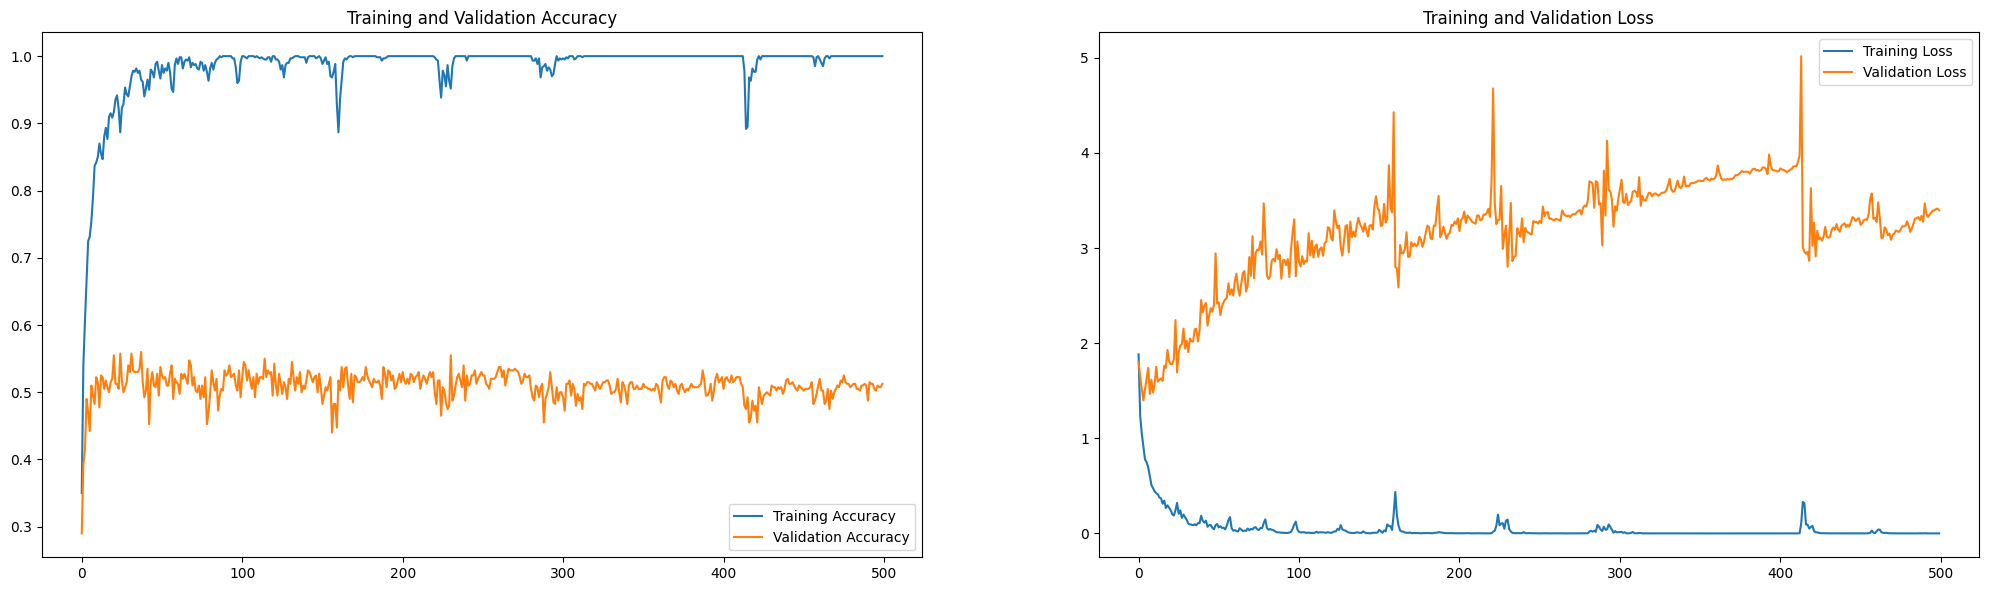

In [18]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
import pickle
history = pickle.load(open('history_500_epoch_tr_GRU.pkl','rb'))
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(500)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)
ax1.plot(epochs_range, acc, label='Training Accuracy', c = '#4CAF50', linewidth=4)
ax1.plot(epochs_range, val_acc, label='Validation Accuracy', c='red', linewidth=4)
ax1.legend()
ax1.set_title('Training and Validation Accuracy',fontsize=18)
ax1.set_ylabel('Accuracy',fontsize=18)
ax1.set_xlabel('Epoch',fontsize=18)

ax2.plot(epochs_range, loss, label='Training Loss',c = '#4CAF50', linewidth=4)
ax2.plot(epochs_range, val_loss, label='Validation Loss', c='red', linewidth=4)
ax2.legend()
ax2.set_title('Training and Validation Loss',fontsize=18)
ax2.set_ylabel('Loss',fontsize=18)
ax2.set_xlabel('Epoch',fontsize=18)
fig.tight_layout(pad=3.0)
#plt.show()
plt.savefig('tfr_GRU_plot1.png',bbox_inches = 'tight')
plt.clf()

<Figure size 1500x600 with 0 Axes>

In [20]:
# 進行預測
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
y_val_single = np.argmax(y_val, axis=1)  # 將y_val轉換為單一類別的整數


13/13 [==============================] - 11s 701ms/step


In [21]:
# 創建一個新的 y_val_single，只包含在 labels 中的類別
y_val_single_filtered = np.where(y_val_single < len(labels), y_val_single, -1)
predictions_filtered = predictions[y_val_single != -1]

In [22]:
# 印出分類報告，但忽略未知類別
from sklearn.metrics import classification_report
print(classification_report(y_val_single_filtered, predictions_filtered, target_names=labels))

              precision    recall  f1-score   support

       blues       0.46      0.57      0.51        40
   classical       0.85      0.85      0.85        40
     country       0.39      0.42      0.40        40
       disco       0.43      0.53      0.47        40
      hiphop       0.43      0.62      0.51        40
        jazz       0.75      0.60      0.67        40
       metal       0.69      0.55      0.61        40
         pop       0.74      0.62      0.68        40
      reggae       0.25      0.23      0.24        40
        rock       0.20      0.12      0.15        40

    accuracy                           0.51       400
   macro avg       0.52      0.51      0.51       400
weighted avg       0.52      0.51      0.51       400



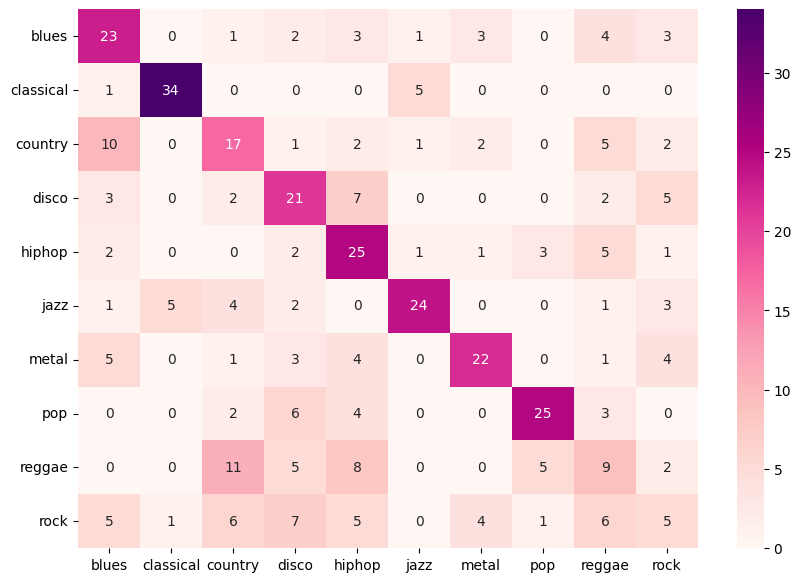

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val_single_filtered, predictions_filtered)
df_cm = pd.DataFrame(cm1, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx7.png',bbox_inches = 'tight')